In [13]:
import numpy as np
import pylab as pl 
import json as json
import pandas as pd

In [66]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
config=json.loads(open('settings.json','r').read())

In [140]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 

In [153]:
logs = pd.read_csv('log_sec.csv')
logs

,timestamp,date,time,temperature,pressure,humidity,avg_pitch_,avg_roll,wave height,wave period
0,1.756421e+09,2025-08-28,23:51:16,38.524,1009.565,62.754,0.7,1.5,0,0
1,1.756422e+09,2025-08-28,23:55:31,38.557,1009.516,62.689,0.6,1.5,0,0
2,1.756422e+09,2025-08-28,23:59:44,38.544,1009.459,62.752,0.5,1.5,0,0
3,1.756422e+09,2025-08-29,00:06:50,38.574,1009.400,62.744,0.8,1.5,0,0
4,1.756424e+09,2025-08-29,00:26:00,38.657,1009.284,62.579,0.7,1.6,0,0
5,1.756424e+09,2025-08-29,00:27:49,38.641,1009.289,62.579,0.7,1.6,0,0
6,1.756424e+09,2025-08-29,00:29:41,38.652,1009.253,62.569,0.7,1.4,0,0
7,1.756424e+09,2025-08-29,00:33:25,38.655,1009.179,62.633,0.7,1.5,0,0
8,1.756425e+09,2025-08-29,00:43:36,38.873,1009.178,62.272,0.7,1.5,0,0
9,1.756425e+09,2025-08-29,00:45:28,38.966,1009.166,62.200,0.7,1.8,0,0


### Debugging ###

In [154]:
freqs    = np.load('freqs.npy')
signal   = np.load('signal.npy')
amp_spec = np.load('amp_spec.npy')
heights  = np.load('heights.npy')

In [155]:
w=40
mavg_signal = moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

720 681


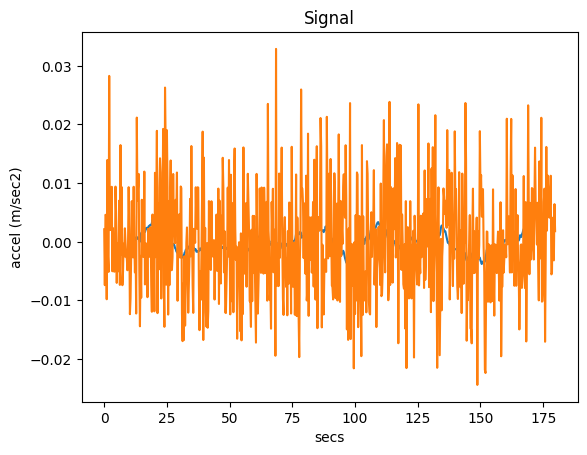

In [156]:
pl.title('Signal')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(w, ls-w )],mavg_signal[w:ls-w])
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal[0:ls])
pl.show()

subtract moving average from signal to clean low frequencies

In [157]:
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

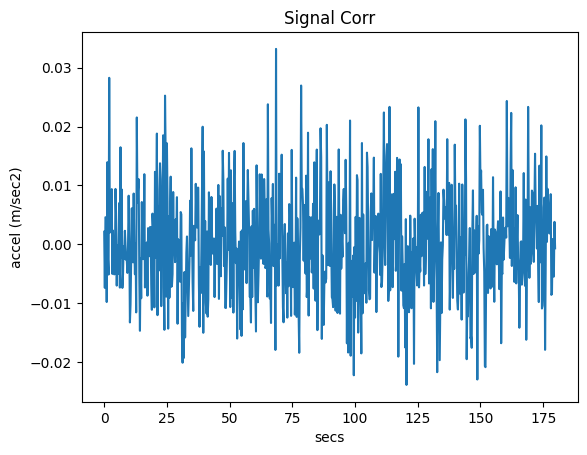

In [158]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [159]:
np.save('signal_corr', signal_corr)

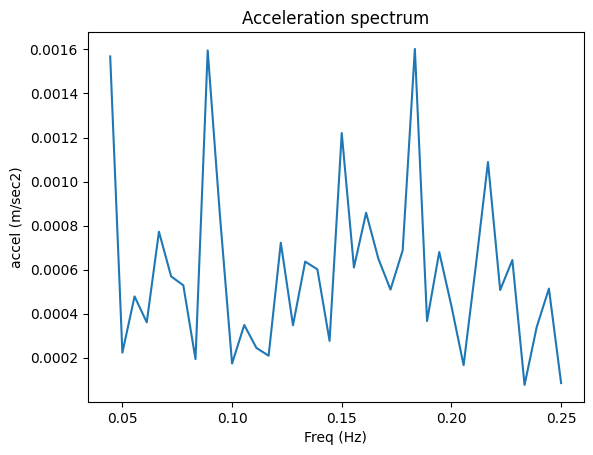

In [160]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.show()

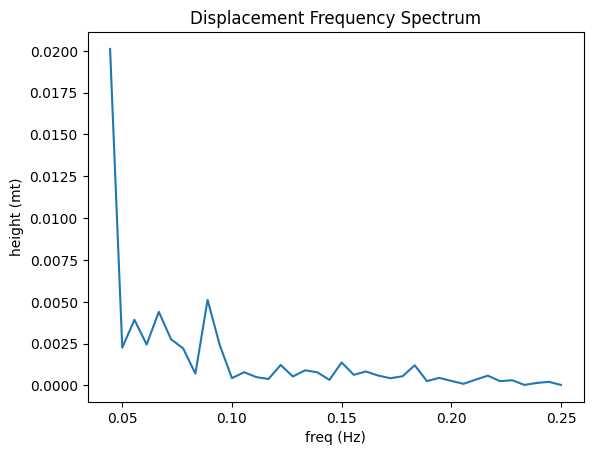

In [161]:
pl.title('Displacement Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.show()